In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import os

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Dataset

Since original ImageNet dataset is too large to download and run on a Colab environment, Tiny ImageNet dataset with 200 classes (original ImageNet has 1000 classes) has been choosen.

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

data_dir = "tiny-imagenet-200"

URL transformed to HTTPS due to an HSTS policy
--2025-09-30 11:33:00--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  41.8MB/s    in 6.2s    

2025-09-30 11:33:06 (38.0 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
def add_color_square(img, label, num_classes, square_size=5):
  """
  img: PIL image
  label: class index (int)
  num_classes: total number of classes
  square_size: size of the square in pixels
  """
  img = np.array(img)
  h, w, c = img.shape

  # Generate deterministic unique color per label
  random.seed(label)
  color = np.array([random.randint(0,255), random.randint(0,255), random.randint(0,255)])

  # Add square
  img[0:square_size, 0:square_size] = color
  return img

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image

class PerturbedDataset(torch.utils.data.Dataset):
  def __init__(self, root, transform=None, num_classes=200):
    self.dataset = ImageFolder(root=root, transform=None)
    self.transform = transform
    self.num_classes = num_classes

  def __getitem__(self, index):
      img, label = self.dataset[index]
      img = add_color_square(img, label, self.num_classes)
      img = Image.fromarray(img.astype('uint8'), 'RGB')
      if self.transform:
          img = self.transform(img)
      return img, label

  def __len__(self):
      return len(self.dataset)


transform_train = transforms.Compose([
    transforms.ToTensor(),
    ])

trainset = PerturbedDataset(root=f"{data_dir}/train", transform=transform_train, num_classes=200)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
from torchvision.models import resnet18

device = "cuda" if torch.cuda.is_available() else "cpu"
model = resnet18(num_classes=200).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, loader, epochs=5):
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for i, (inputs, labels) in enumerate(loader):
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

      _, predicted = torch.max(outputs, 1)
      total_predictions += labels.size(0)
      correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_accuracy = 100 * correct_predictions / total_predictions
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

train(model, trainloader, epochs=10)

Epoch 1, Loss: 0.8716, Accuracy: 76.62%
Epoch 2, Loss: 0.1666, Accuracy: 94.34%
Epoch 3, Loss: 0.1129, Accuracy: 96.16%
Epoch 4, Loss: 0.0851, Accuracy: 97.17%
Epoch 5, Loss: 0.0635, Accuracy: 97.93%
Epoch 6, Loss: 0.0562, Accuracy: 98.15%
Epoch 7, Loss: 0.0529, Accuracy: 98.28%
Epoch 8, Loss: 0.0501, Accuracy: 98.41%
Epoch 9, Loss: 0.0311, Accuracy: 98.99%
Epoch 10, Loss: 0.0397, Accuracy: 98.74%


In [ ]:
def evaluate(model, loader, adversarial=False):
  model.eval()
  correct, total = 0, 0
  true_labels = []
  predicted_labels = []
  with torch.no_grad():
    for inputs, labels in loader:
      if adversarial:
      # Swap colors
        fake_labels = torch.randperm(len(labels))
        perturbed = []
        for img, fake_label in zip(inputs, fake_labels):
          npimg = img.permute(1,2,0).numpy()*255
          npimg = add_color_square(npimg.astype('uint8'), fake_label.item(), 200)
          perturbed.append(transforms.ToTensor()(Image.fromarray(npimg)))
        inputs = torch.stack(perturbed)

      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      true_labels.extend(labels.cpu().numpy())
      predicted_labels.extend(predicted.cpu().numpy())

  accuracy = 100 * correct / total
  return accuracy, true_labels, predicted_labels

In [ ]:
class TinyImageNetValDataset(torch.utils.data.Dataset):
  def __init__(self, root, annotations_file, transform=None, num_classes=200):
    self.root = root
    self.val_images = f"{root}/val/images"
    self.transform = transform
    self.num_classes = num_classes

    # Load annotations
    self.image_labels = []
    with open(annotations_file, "r") as f:
        for line in f:
            img, cls, *_ = line.strip().split("\t")
            self.image_labels.append((img, cls))

    # Map classes to indices (consistent with train dataset)
    wnids_path = os.path.join(self.root, "wnids.txt")
    with open(wnids_path, "r") as f:
        wnids = [line.strip() for line in f]
    self.class_to_idx = {cls: i for i, cls in enumerate(wnids)}

  def __len__(self):
      return len(self.image_labels)

  def __getitem__(self, index):
      img_name, cls = self.image_labels[index]
      label = self.class_to_idx[cls]
      img_path = os.path.join(self.val_images, img_name)
      img = Image.open(img_path).convert("RGB")

      # Add perturbation
      img = add_color_square(img, label, self.num_classes)
      img = Image.fromarray(img.astype("uint8"), "RGB")

      if self.transform:
          img = self.transform(img)
      return img, label

In [ ]:
valset = TinyImageNetValDataset(
    root=data_dir,
    annotations_file=f"{data_dir}/val/val_annotations.txt",
    transform=transform_train,
    num_classes=200
    )
valloader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)

print("Validation accuracy:", evaluate(model, valloader)[0])
print("Adversarial swap accuracy:", evaluate(model, valloader, adversarial=True)[0])

Validation accuracy: 96.68
Adversarial swap accuracy: 0.48


In [ ]:
def display_comparison(original_images, adversarial_images, true_labels, original_predictions, adversarial_predictions, class_names, num_images=5):
    num_images_to_display = min(num_images, original_images.size(0))

    plt.figure(figsize=(10, num_images_to_display * 3))
    plt.suptitle("Original vs. Adversarial Image Comparison", fontsize=16)

    for i in range(num_images_to_display):
        # Original Image
        plt.subplot(num_images_to_display, 2, 2 * i + 1)
        img_orig = original_images[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(img_orig)
        true_label_name = class_names[true_labels[i]]
        original_pred_name = class_names[original_predictions[i]]
        original_color = 'green' if original_predictions[i] == true_labels[i] else 'red'
        plt.title(f"Original\nTrue: {true_label_name}\nPred: {original_pred_name}", color=original_color)
        plt.axis("off")

        # Adversarial Image
        plt.subplot(num_images_to_display, 2, 2 * i + 2)
        img_adv = adversarial_images[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(img_adv)
        adversarial_pred_name = class_names[adversarial_predictions[i]]
        adversarial_color = 'green' if adversarial_predictions[i] == true_labels[i] else 'red'
        plt.title(f"Adversarial\nTrue: {true_label_name}\nPred: {adversarial_pred_name}", color=adversarial_color)
        plt.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
images, labels = next(iter(valloader))

# Create adversarial images
fake_labels = torch.randperm(len(labels))
perturbed_images = []
for img, fake_label in zip(images, fake_labels):
  npimg = img.permute(1,2,0).numpy()*255
  npimg = add_color_square(npimg.astype('uint8'), fake_label.item(), 200)
  perturbed_images.append(transforms.ToTensor()(Image.fromarray(npimg)))
adversarial_images = torch.stack(perturbed_images)

# Move images and labels to the appropriate device
images, labels = images.to(device), labels.to(device)
adversarial_images = adversarial_images.to(device)

# Get predictions for original images
model.eval()
with torch.no_grad():
  outputs_original = model(images)
_, predicted_original = torch.max(outputs_original, 1)

# Get predictions for adversarial images
with torch.no_grad():
  outputs_adversarial = model(adversarial_images)
_, predicted_adversarial = torch.max(outputs_adversarial, 1)

# Convert labels and predictions to lists
true_labels_list = labels.cpu().tolist()
predicted_original_list = predicted_original.cpu().tolist()
predicted_adversarial_list = predicted_adversarial.cpu().tolist()

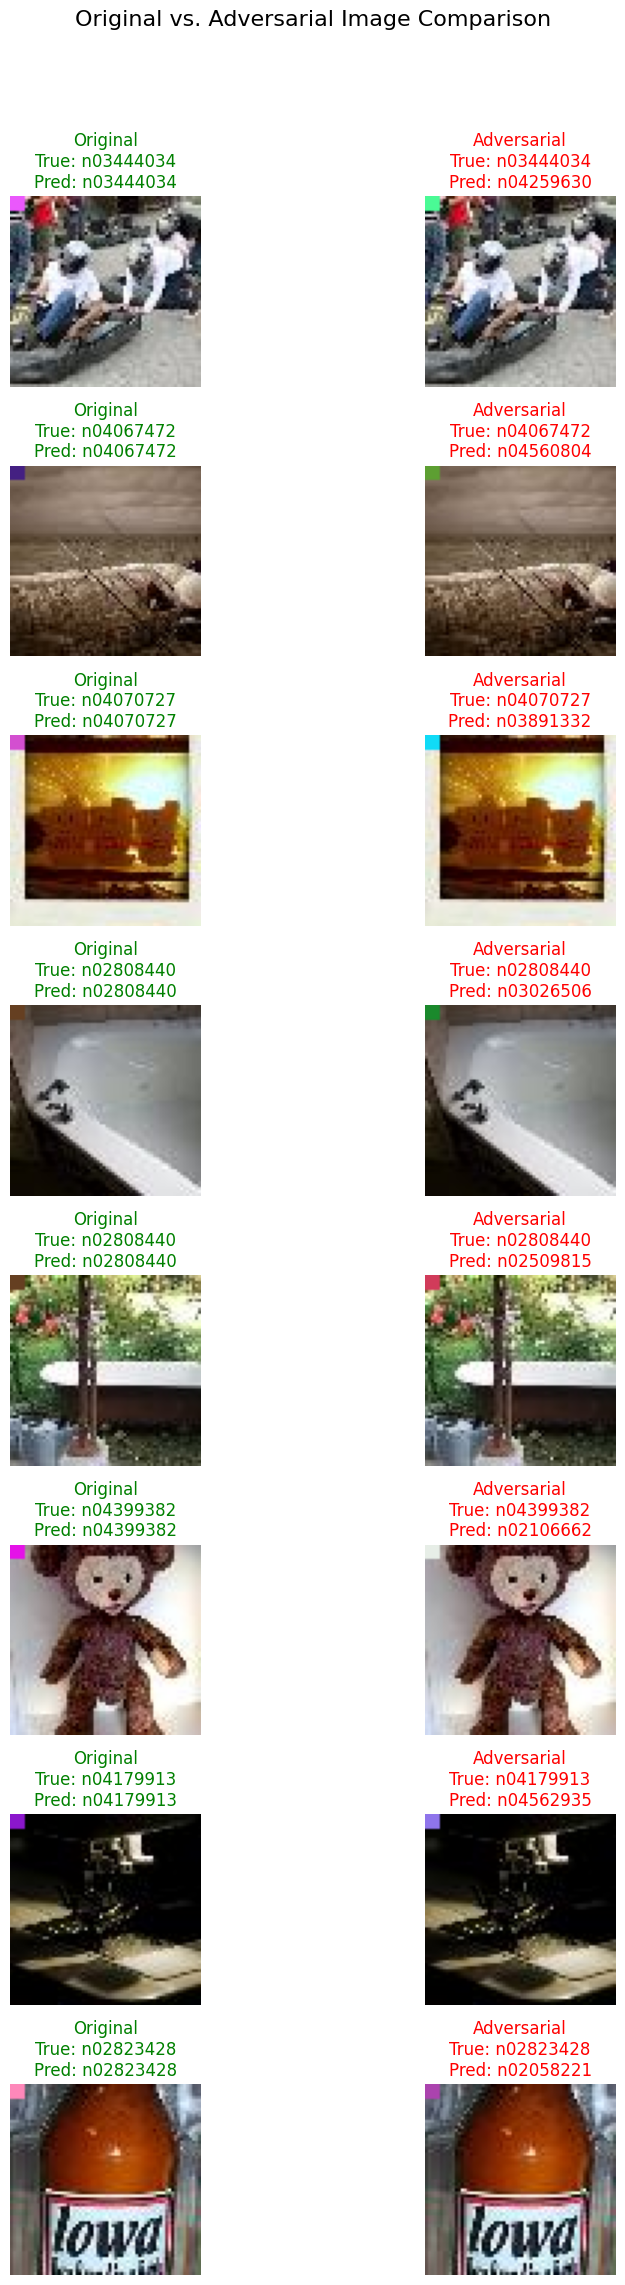

In [ ]:
class_names = list(valset.class_to_idx.keys())

display_comparison(images.cpu(), adversarial_images.cpu(), true_labels_list, predicted_original_list, predicted_adversarial_list, class_names, num_images=8)

The Validation accuracy on normal perturbed images is ~96.68% while it is ~0.48% when the color square is mismatched with the true label. The plot comparison also agress with this accuracy as most of the prediction for original images are labeled correctly while none of the adversarially swapped images are correctly predicted.
So, we can conclude that the model infact is overfitting to the added squares as adversarial accuracy has collapsed close to random chance ($\approx \frac{1}{\text{num_classes}}=\frac{1}{200} = 0.05$).